In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import itertools # may be used for combinations
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import TimeDistributed
import joblib
import os

from Logic import WindowGenerator, Baseline

tf.config.set_visible_devices([], 'GPU')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [6]:
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPUs Available:  0


In [7]:
# Load the data
csv_file2 = 'Data/latpho_mix_h.csv'
df = pd.read_csv(csv_file2)
df

,datetime,Temperature,Salinity,wl
0,10/4/2017 22:00,30.230000,0.130000,0.836000
1,10/4/2017 23:00,30.186667,0.131667,0.713500
2,10/5/2017 0:00,30.223333,0.130000,0.564000
3,10/5/2017 1:00,30.208333,0.130000,0.589000
4,10/5/2017 2:00,30.186667,0.130000,0.788333
...,...,...,...,...
59660,7/25/2024 18:00,30.521667,0.180000,0.287333
59661,7/25/2024 19:00,30.530000,0.178333,1.058833
59662,7/25/2024 20:00,30.516667,0.180000,1.509200
59663,7/25/2024 21:00,30.501667,0.180000,1.752667


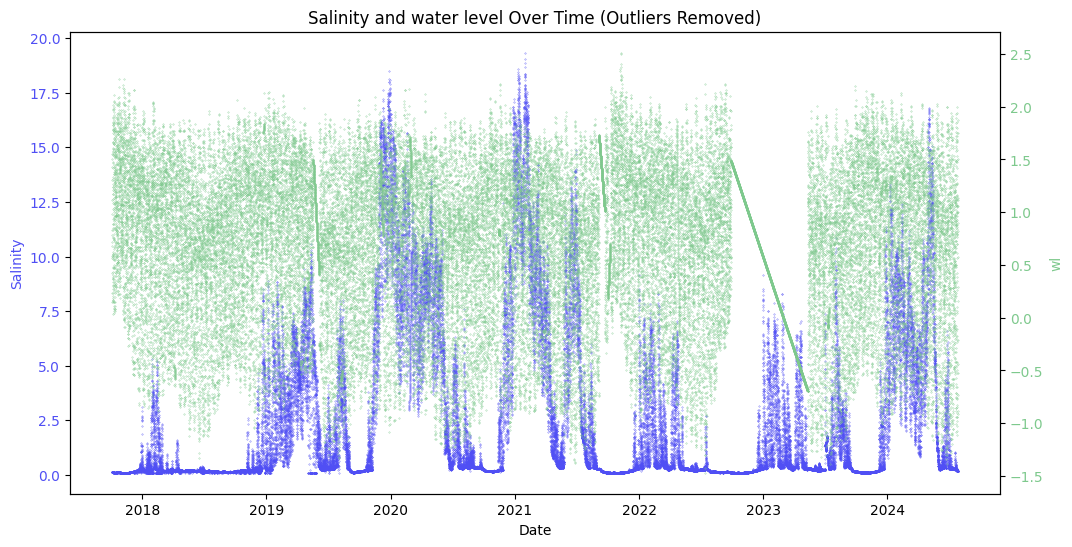

In [8]:

# Convert date_time to datetime format and set as the index
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M')
df['date_time_copy'] = df['datetime']
df.set_index('datetime', inplace=True)

# Filter for columns 'Salinity' and 'Sensor_Depth' and remove rows with NaN values
# df2 = df2.loc[: , ['Salinity']]

# Plot both columns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Salinity data
ax1.plot(df.index, df['Salinity'], '.', markersize=0.5, label='Salinity', color='#504ff4')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity', color='#504ff4')
ax1.tick_params(axis='y', labelcolor='#504ff4')

# Plot wl data
ax2 = ax1.twinx()
ax2.plot(df.index, df['wl'], '.', markersize=0.5, label='wl', color='#7ec98d')
ax2.set_ylabel('wl', color='#7ec98d')
ax2.tick_params(axis='y', labelcolor='#7ec98d')

# Title and show plot
plt.title('Salinity and water level Over Time (Outliers Removed)')
plt.show()

In [10]:
df = df[(df["date_time_copy"] > pd.Timestamp('2018-10-01')) & (df["date_time_copy"] < pd.Timestamp('2022-06-01'))]
df = df[df["Salinity"] > 0]

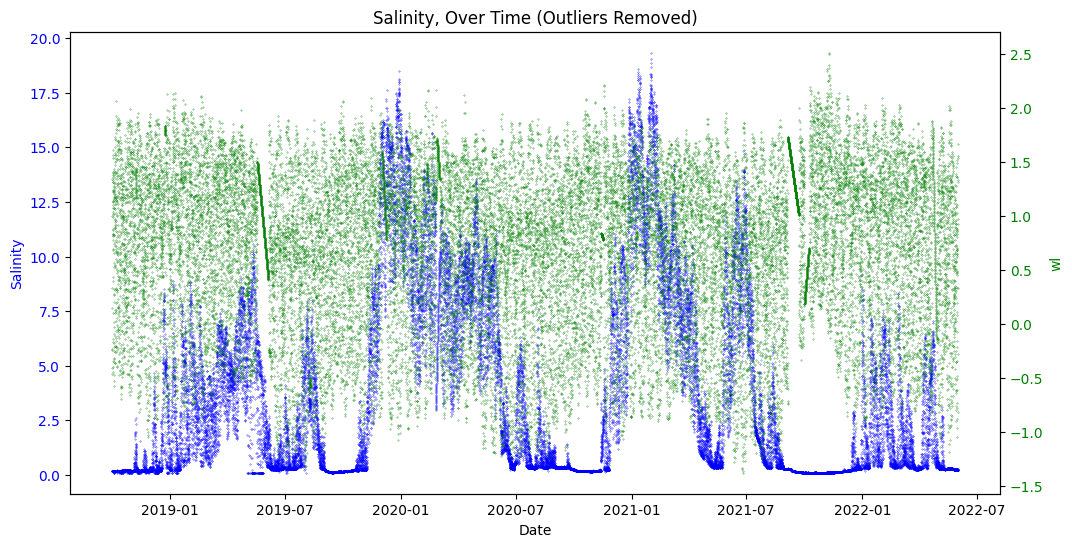

In [11]:
# Plot both columns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Salinity data
ax1.plot(df.index, df['Salinity'], '.', markersize=0.5, label='Salinity', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot wl data
ax2 = ax1.twinx()
ax2.plot(df.index, df['wl'], '.', markersize=0.5, label='wl', color='g')
ax2.set_ylabel('wl', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Title and show plot
plt.title('Salinity, Over Time (Outliers Removed)')
plt.show()

In [12]:
df.drop(columns=['Temperature'], inplace=True)
df.columns

Index(['Salinity', 'wl', 'date_time_copy'], dtype='object')

In [13]:
# Assuming df.index is a DateTimeIndex
date_time = df.pop('date_time_copy')  # original datetime column
timestamp_s = date_time.map(pd.Timestamp.timestamp)  # seconds since epoch

# Daily cycle (e.g. tidal)
day = 24.0 * 60 * 60
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

# Monthly (yearly) cycle
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

df['fractional_year'] = df.index.year + (df.index.dayofyear - 1) / 365.0
df['year_sin'] = np.sin(2 * np.pi * (df['fractional_year'] % 1))
df['year_cos'] = np.cos(2 * np.pi * (df['fractional_year'] % 1))
df.drop(columns=['fractional_year'], inplace=True)

In [14]:
df.columns

Index(['Salinity', 'wl', 'Day sin', 'Day cos', 'month_sin', 'month_cos',
       'year_sin', 'year_cos'],
      dtype='object')

In [15]:
# Define column indices dictionary for df
column_indices = {name: i for i, name in enumerate(df.columns)}

# Split data into training, validation, and test sets
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Define number of features based on df1's columns
num_features = df.shape[1]

In [16]:
print("All columns in train_df:")
print(train_df.columns.tolist())

All columns in train_df:
['Salinity', 'wl', 'Day sin', 'Day cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos']


In [17]:
label_columns = ['Salinity', 'wl']
input_features = [col for col in train_df.columns if col not in label_columns]
print("\nExpected input features:", input_features)
print("Expected feature count:", len(input_features))  # Should match 8


Expected input features: ['Day sin', 'Day cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos']
Expected feature count: 6


In [18]:
column_indices

{'Salinity': 0,
 'wl': 1,
 'Day sin': 2,
 'Day cos': 3,
 'month_sin': 4,
 'month_cos': 5,
 'year_sin': 6,
 'year_cos': 7}

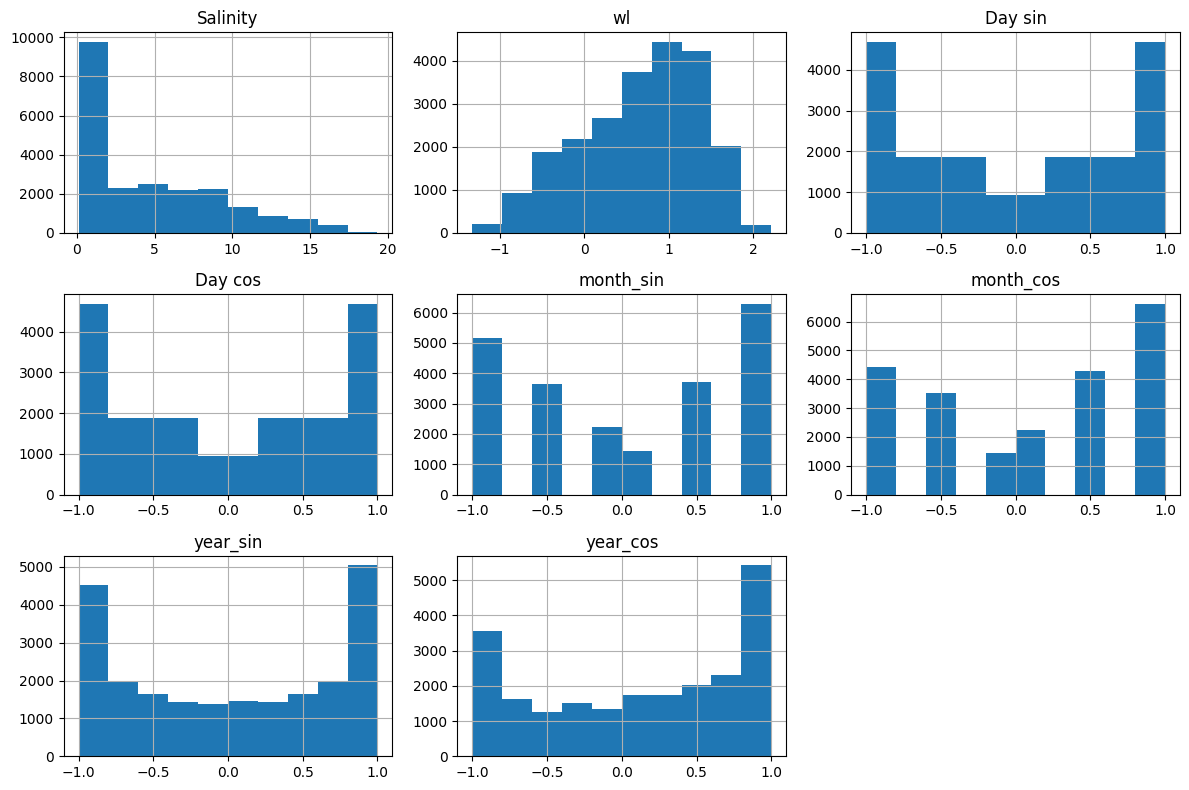

In [19]:
train_df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [20]:
# Create a folder for the models
folderName = "Improved_more_Models"
os.makedirs(f"Models/{folderName}", exist_ok=True)

--------


**Normalize Step**

Save Scaler

In [21]:
# Suppose we have a DataFrame df, we fit a MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform together
scaler.fit(train_df[['Salinity', 'wl']])

joblib.dump(scaler, f'Models/{folderName}/{folderName}.pkl')

['Models/Improved_more_Models/Improved_more_Models.pkl']

In [22]:
train_df.loc[:, ['Salinity', 'wl']] = scaler.transform(train_df[['Salinity', 'wl']])
val_df.loc[:, ['Salinity', 'wl']]   = scaler.transform(val_df[['Salinity', 'wl']])
test_df.loc[:, ['Salinity', 'wl']]  = scaler.transform(test_df[['Salinity', 'wl']])

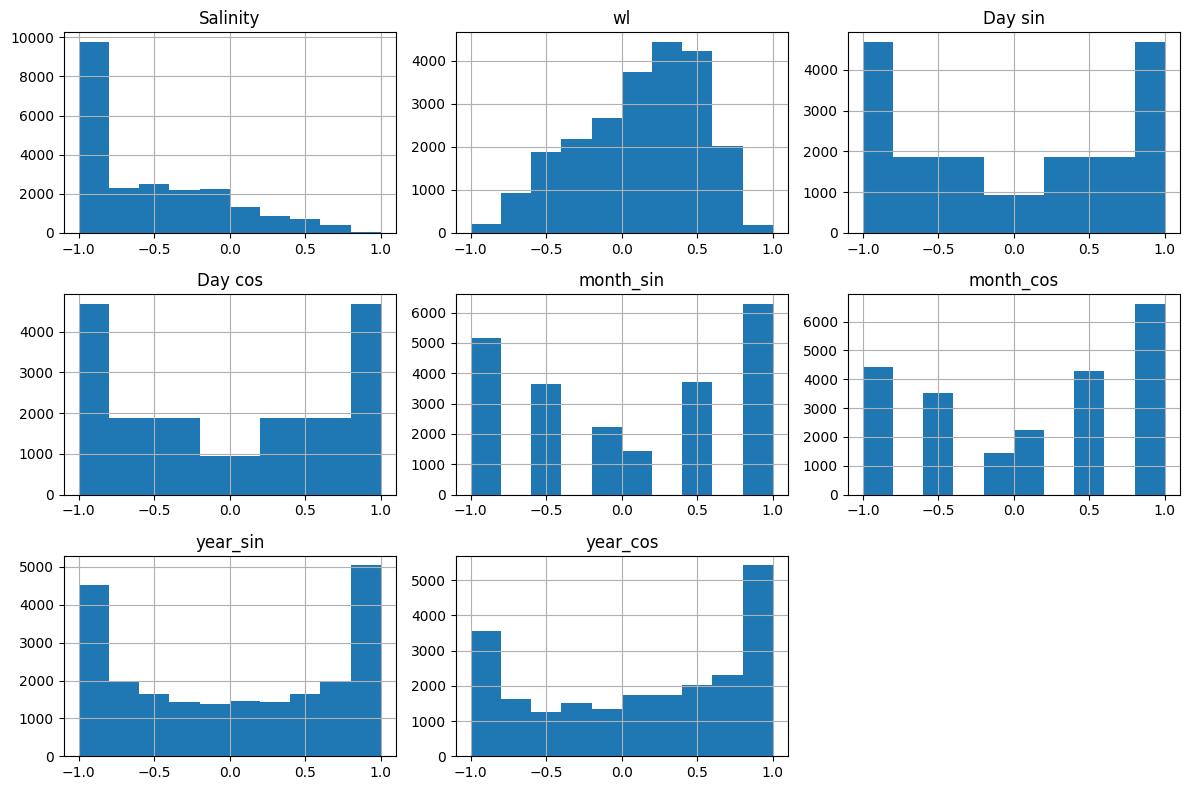

In [23]:
train_df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_30584\2955195469.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


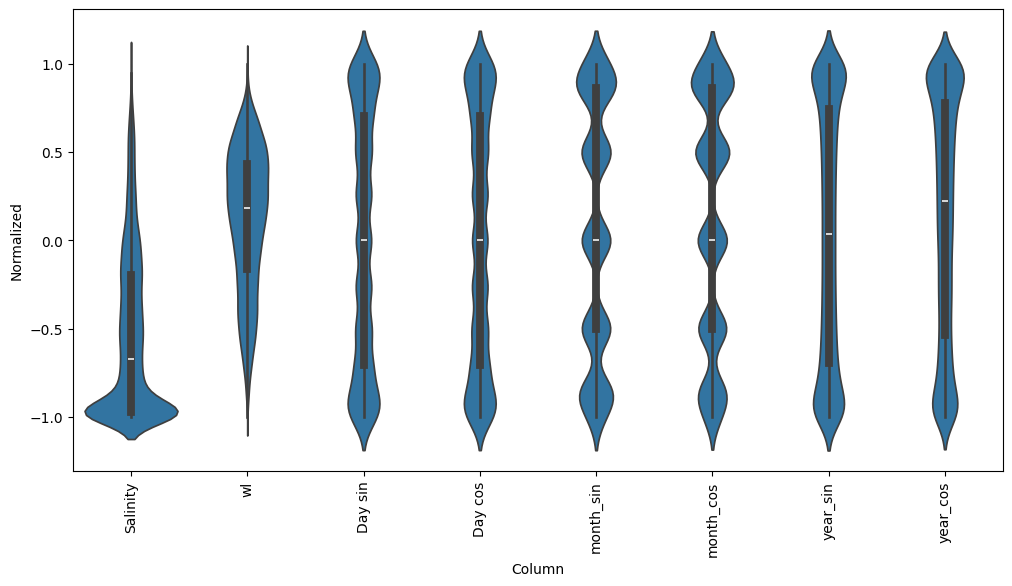

In [24]:
df_melt = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_melt)
_ = ax.set_xticklabels(df.keys(), rotation=90)

-----


Define Window (Use longer window helps lstm learn)

In [25]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df,  # Provide actual DataFrame
    val_df=val_df,      # Provide actual DataFrame
    test_df=test_df,    # Provide actual DataFrame
    label_columns=label_columns # Specify the label columns
)

In [26]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=label_columns,train_df=train_df, val_df=val_df, test_df=test_df)

In [27]:
multi_window = WindowGenerator(
    input_width=24, label_width=24, shift=24,
    train_df=train_df,  # Provide actual DataFrame
    val_df=val_df,      # Provide actual DataFrame
    test_df=test_df,    # Provide actual DataFrame
    label_columns=label_columns  # Specify the label columns
)

In [28]:
weekToOne_window = WindowGenerator(
    input_width=168, label_width=1, shift=1,
    train_df=train_df,  # Provide actual DataFrame
    val_df=val_df,      # Provide actual DataFrame
    test_df=test_df,    # Provide actual DataFrame
    label_columns=label_columns  # Specify the label columns
)

In [29]:
week_window = WindowGenerator(
    input_width=168, label_width=168, shift=168,
    label_columns=label_columns,
    train_df=train_df, 
    val_df=val_df, 
    test_df=test_df)

In [30]:
# w2 = multi_window

In [31]:
w3 = week_window

-----

In [32]:
baseline = Baseline(label_index=column_indices['Salinity'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.6035 - mean_absolute_error: 0.4988


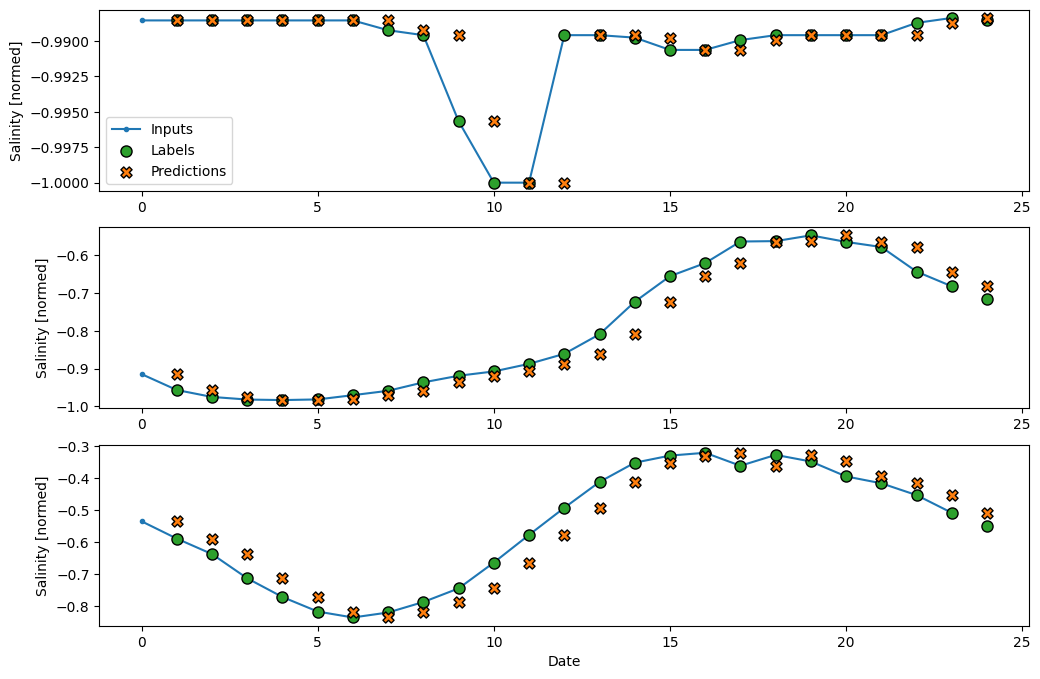

In [245]:
wide_window.plot(baseline)

In [33]:
# Auto Build
def build_model(filters,lstm_units, kernel_size, dropout_rate):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters, kernel_size=kernel_size, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
    ])
    return model

In [34]:
def compile_and_fit(model, window, patience=4, max_epochs=30):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True,)
    
    # # Define exponential decay schedule
    # initial_lr = 0.001  # Starting learning rate
    # decay_steps = 1000  # Number of steps before applying decay
    # decay_rate = 0.96  # Decay rate

    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=initial_lr,
    #     decay_steps=decay_steps,
    #     decay_rate=decay_rate,
    #     staircase=False  # Smooth exponential decay; use True for discrete steps
    # )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    history = model.fit(
        window.train,
        epochs=max_epochs,
        validation_data=window.val,
        callbacks=[early_stopping],
        verbose=1
        
    )
    return history

----

Define Models

In [35]:
# not any more
Best = tf.keras.models.Sequential(
    [
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # TimeDistributed Dense for output
    TimeDistributed(tf.keras.layers.Dense(2))
    ],
    name='Best')

In [36]:
LSTM_Model_conv_2_lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # TimeDistributed Dense for output
    TimeDistributed(tf.keras.layers.Dense(2))
], name='LSTM_Model_conv_2_lstm_2')

In [37]:
LSTM_Model_conv_2_lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # TimeDistributed Dense for output
    TimeDistributed(tf.keras.layers.Dense(2))
], name='LSTM_Model_conv_2_lstm_3')

In [38]:
LSTM_Model_conv_3_lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # TimeDistributed Dense for output
    TimeDistributed(tf.keras.layers.Dense(2))
], name='LSTM_Model_conv_3_lstm_3')

In [39]:
LSTM_Model_conv_3_lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # TimeDistributed Dense for output
    TimeDistributed(tf.keras.layers.Dense(2))
], name='LSTM_Model_conv_3_lstm_4')

In [40]:
LSTM_Model_conv_4_lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # TimeDistributed Dense for output
    TimeDistributed(tf.keras.layers.Dense(2))
], name='LSTM_Model_conv_4_lstm_4')

In [42]:
LSTM_Model_conv_5_lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # TimeDistributed Dense for output
    TimeDistributed(tf.keras.layers.Dense(2))
], name='LSTM_Model_conv_5_lstm_4')

In [41]:
LSTM_Model_conv_5_lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu'),
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # TimeDistributed Dense for output
    TimeDistributed(tf.keras.layers.Dense(2))
], name='LSTM_Model_conv_5_lstm_5')

In [43]:
models = [Best, LSTM_Model_conv_2_lstm_2, LSTM_Model_conv_2_lstm_3, LSTM_Model_conv_3_lstm_3]

-----

In [44]:
w3.test_df.head(5)

,Salinity,wl,Day sin,Day cos,month_sin,month_cos,year_sin,year_cos
datetime,,,,,,,,
2022-01-18 02:00:00,-0.950433,-0.597895,0.500000,8.660254e-01,0.5,0.866025,0.288482,0.957485
2022-01-18 03:00:00,-0.966551,-0.297186,0.707107,7.071068e-01,0.5,0.866025,0.288482,0.957485
2022-01-18 04:00:00,-0.962218,0.074848,0.866025,5.000000e-01,0.5,0.866025,0.288482,0.957485
2022-01-18 05:00:00,-0.951300,0.345017,0.965926,2.588190e-01,0.5,0.866025,0.288482,0.957485
2022-01-18 06:00:00,-0.918718,0.544519,1.000000,1.090006e-11,0.5,0.866025,0.288482,0.957485


In [45]:
print(next(iter(w3.train))[1].shape)  # check target (label) shape

(32, 168, 2)


In [46]:
# filters = [16 ,32, 64]
# lstm_units_list = [32, 64, 128]
# kernel_sizes = [3, 5, 7]
# dropouts = [0.1, 0.3, 0.5]

results = []

# for filters, lstm_units, kernel_size, dropout in itertools.product(filters, lstm_units_list, kernel_sizes, dropouts):
#     config_name = f"LSTM{lstm_units}_F{filters}_K{kernel_size}_D{dropout}"
#     print(f"Training {config_name}")

#     model = build_model(filters, lstm_units, kernel_size, dropout)
#     compile_and_fit(model, w3)

#     val_result = model.evaluate(w3.val, verbose=0, return_dict=True)
#     test_result = model.evaluate(w3.test, verbose=0, return_dict=True)

#     results.append({
#         "model": config_name,
#         "val_mae": val_result['mean_absolute_error'],
#         "test_mae": test_result['mean_absolute_error']
#     })
    
for model in models:
    print(f"Training {model.name}")
    
    compile_and_fit(model, w3)
    
    val_result = model.evaluate(w3.val, verbose=0, return_dict=True)
    test_result = model.evaluate(w3.test, verbose=0, return_dict=True)
    
    results.append({
        "model": model.name,
        "val_mae": val_result['mean_absolute_error'],
        "test_mae": test_result['mean_absolute_error']
    })
    

Training Best
Epoch 1/30
693/693 ━━━━━━━━━━━━━━━━━━━━ 98s 131ms/step - loss: 0.2147 - mean_absolute_error: 0.2767 - val_loss: 0.1491 - val_mean_absolute_error: 0.2235
Epoch 2/30
693/693 ━━━━━━━━━━━━━━━━━━━━ 93s 134ms/step - loss: 0.1269 - mean_absolute_error: 0.2243 - val_loss: 0.1117 - val_mean_absolute_error: 0.2057
Epoch 3/30
693/693 ━━━━━━━━━━━━━━━━━━━━ 95s 137ms/step - loss: 0.0999 - mean_absolute_error: 0.2085 - val_loss: 0.0946 - val_mean_absolute_error: 0.1927
Epoch 4/30
693/693 ━━━━━━━━━━━━━━━━━━━━ 93s 134ms/step - loss: 0.0848 - mean_absolute_error: 0.1938 - val_loss: 0.0846 - val_mean_absolute_error: 0.1814
Epoch 5/30
693/693 ━━━━━━━━━━━━━━━━━━━━ 93s 134ms/step - loss: 0.0722 - mean_absolute_error: 0.1777 - val_loss: 0.0758 - val_mean_absolute_error: 0.1714
Epoch 6/30
693/693 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - loss: 0.0635 - mean_absolute_error: 0.1665 - val_loss: 0.0755 - val_mean_absolute_error: 0.1683
Epoch 7/30
693/693 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - loss: 0.058

Save Model

In [47]:
 # Save the model after training
for model in models:
    model_path = f"Models/{folderName}/{model.name}.keras"
    model.save(model_path)

In [48]:
# Evaluate the Baseline model
baseline = Baseline(label_index=column_indices['Salinity'])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_result = baseline.evaluate(w3.val, return_dict=True)
test_result = baseline.evaluate(w3.test, return_dict=True)

results.append({
    "model": "Baseline",
    "val_mae": val_result['mean_absolute_error'],
    "test_mae": test_result['mean_absolute_error']
})

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.6373 - mean_absolute_error: 0.5550
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.5762 - mean_absolute_error: 0.5567


In [49]:
results_df = pd.DataFrame(results)
print(results_df)

                      model   val_mae  test_mae
0                      Best  0.158985  0.177838
1  LSTM_Model_conv_2_lstm_2  0.157445  0.173278
2  LSTM_Model_conv_2_lstm_3  0.160070  0.168280
3  LSTM_Model_conv_3_lstm_3  0.150279  0.173902
4                  Baseline  0.554962  0.556704


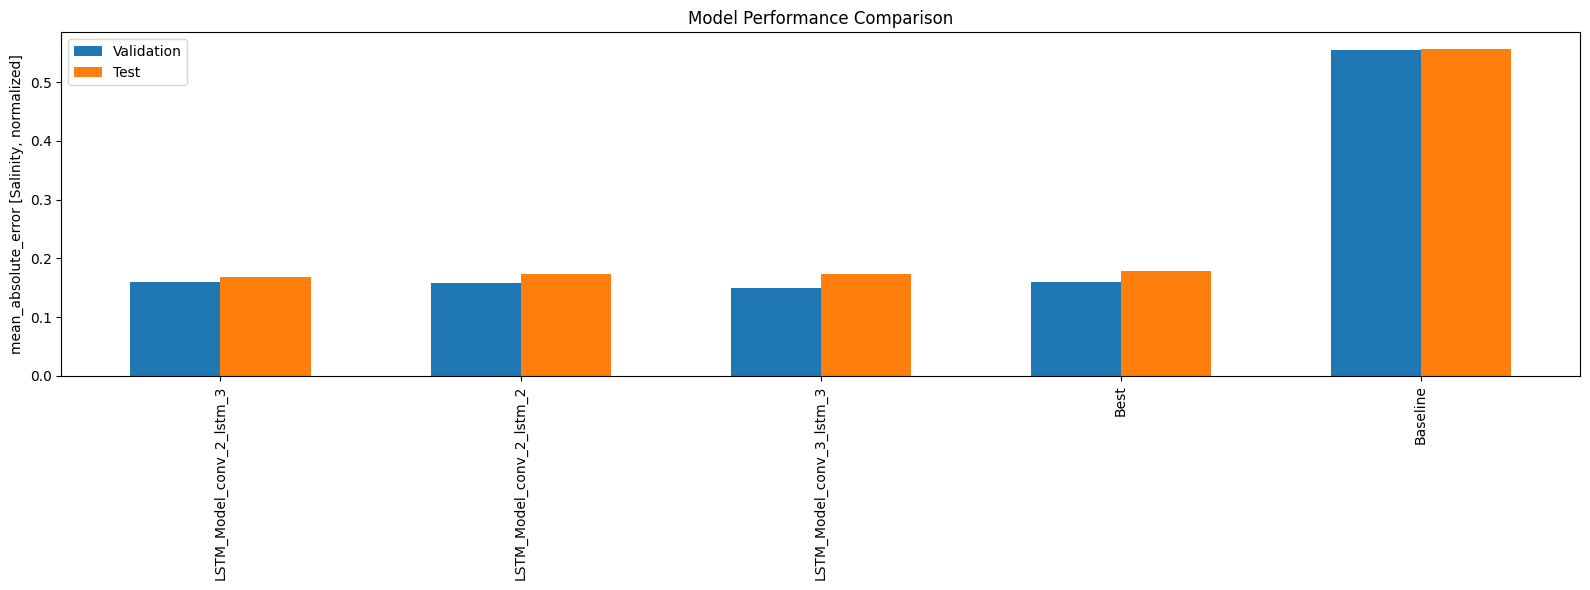

In [50]:
# Convert your list of dictionaries to a DataFrame
df_results = pd.DataFrame(results)

# Now you can sort it
df_results = df_results.sort_values(by='test_mae')

# Save the DataFrame to a CSV file
df_results.to_csv(f"Models/{folderName}/{folderName}.csv", index=False)

# Bar width and positions
x = np.arange(len(df_results))
width = 0.3

# Create the plot
plt.figure(figsize=(16, 6))
plt.bar(x - width/2, df_results['val_mae'], width, label='Validation')
plt.bar(x + width/2, df_results['test_mae'], width, label='Test')

# Labels and ticks
plt.ylabel('mean_absolute_error [Salinity, normalized]')
plt.xticks(ticks=x, labels=df_results['model'], rotation=90)
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()

---

Multi-step Code (Not finish)

In [ ]:
# baseline = Baseline(label_index=column_indices['Salinity'])

# baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
#                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

# val_performance_w2 = {}
# performance_w2 = {}

# val_performance_w2['Baseline'] = baseline.evaluate(w2.val, return_dict=True)
# performance_w2['Baseline'] = baseline.evaluate(w2.test, verbose=0, return_dict=True)

In [ ]:
# # Safely access 'mean_absolute_error' regardless of the structure
# def extract_metric(data, metric_name):
#     result = []
#     for key, value in data.items():
#         if isinstance(value, dict):  # Case: value is a single dictionary
#             result.append(value[metric_name])
#         elif isinstance(value, list):  # Case: value is a list of dictionaries
#             result.append(value[0][metric_name])  # Use the first dictionary in the list
#     return result

# # Extract values
# val_mae = extract_metric(val_performance_w2, 'mean_absolute_error')
# test_mae = extract_metric(performance_w2, 'mean_absolute_error')

# # Plot the data
# x = np.arange(len(performance_w2))
# width = 0.3

# plt.figure(figsize=(15, 6))  # width=10 inches, height=6 inches
# plt.ylabel('mean_absolute_error [Salinity, normalized]')
# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance_w2.keys(), rotation=90)
# plt.legend()
# plt.show()